In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



*Based on "A simple introduction to Markov Chain Monte–Carlo sampling" by [Ravenzwaaij et al.](https://link.springer.com/content/pdf/10.3758%2Fs13423-016-1015-8.pdf):*

### Introduction

In an [earlier post](/2020/03/01/markov-chain-monte-carlo-mcmc-metropolis-hastings/), I discussed the basic idea of MCMC methods, and provided an overview of the Metropolis algorithm. In this section, I'll jump straight into the motivation for Gibbs Sampling, and an overview of how the algorithm works.

### What is the point of Gibbs Sampling if we already know the Metropolis algorithm?

Both Gibbs Sampling and the Metropolis Algorithm are actually pretty similar in terms of the general structure. Both use an accept-reject algorithm to iteratively draw samples from the underlying unknown distribution to move towards the most likely distribution. The key difference is in the proposal step for the new values in every iteration - while the Metropolis algorithm samples from the *joint* probability distribution of the parameters, Gibbs Sampling draws from the *conditional* distribution instead. 

Mathematically, this means that the Metropolis algorithm compares $\frac{L^{met}_1}{L^{met}_{0}} = \frac{\prod_{i = 1}^{n}{P(\mathbf{x_i}|\mu_1, \sigma_1)}}{\prod_{i = 1}^{n}{P(\mathbf{x_i}|\mu_0, \sigma_0)}}$; that is, what is the likelihood of the data under the current set of parameters $(\mu_0, \sigma_0)$ compared to the likelihood of the data under a new set of parameters $(\mu_1, \sigma_1)$. Notice that my new parameters are varied at the same time, i.e. they are sampled jointly from the unknown distribution of $(\mu, \sigma)$.

While the Metropolis algorithm works well in most cases, there are situations where it can converge too slowly to provide a meaningful answer. For instance, if the underlying parameters are highly correlated, or if the dimensionality of the parameter set is too high (i.e. too many parameters for you to guess), the Metropolis algorithm can converge too slowly to be useful. 

### Gibbs Sampling

As mentioned above, the main insight of Gibbs sampling is: wherever drawing from the joint distribution is suboptimal, we can try to draw from the *condition* distribution instead. In this way, the joint distribution between parameters is respected over an extended number of iterations, and unidimensional sampling is much easier to evaluate.<sup id="a1">[1](#f1)</sup>

The Gibbs Sampling Algorithm is summarised below: <br>

1. Give your best guess for the parameter(s) of interest. In this case, let's say this is $\mu$ and $\sigma$. We will call this $\mu_0$ and $\sigma_0$
2. Next, we compute the likelihood $L_0$ of the parameter being $\mu_0$ conditional on the data we observe, or $P(\mu_0 | Data)$. By Bayes' rule, this is equal to $\frac{P(Data | \mu_0, \sigma_0) \cdotp P(\mu_0, \sigma_0)}{P(Data)}$.
3. Add a random perturbation to **one** of your parameters, holding everything else constant. Suppose we add a random perturbation to $\mu_0$. Let's call this new parameter $\mu_1$.
4. Again, compute the likelihood $L_1$ of the parameters being $(\mu_1, \sigma_0)$ conditional on the data you observe, $P(\mu_1, \sigma_0 | Data)$
5. Compare the likelihood scores of hyperparameters given the data. 
    a. If $L_1$ > $L_0$, $(\mu_1, \sigma_0)$ becomes your best guess
    b. If $L_1$ <= $L_0$, $(\mu_1, \sigma_0)$ is chosen with probability $L_1 / L_2$
6. For illustration, let's assume the proposed $\mu_1$ was accepted. We now hold $\mu_1$ constant, and add a random perturbation to $\sigma_0$. Let's now call this $\sigma_1$.
7. Compute the likelihood $L_2$ of the parameters being $(\mu_1, \sigma_1)$ conditional on the data you observe, $P(\mu_1, \sigma_1 | Data)$
8. Compare the likelihood scores of hyperparameters given the data. 
    a. If $L_2$ > $L_1$, $(\mu_1, \sigma_1)$ becomes your best guess
    b. If $L_2$ <= $L_1$, $(\mu_1, \sigma_1)$ is chosen with probability $L_2 / L_1$
9. Repeat from step 1 for a given number of iterations

In [2]:
gibbs_sampling <- function(data, proposed_mu, proposed_sigma, niter = 500){
  
  proposed_param = data.frame(proposed_mu = proposed_mu, proposed_sigma = proposed_sigma)
  accept_param = data.frame(accept_mu = proposed_mu, accept_sigma = proposed_sigma)
  
  current_mu = proposed_mu
  current_sigma = proposed_sigma
  
  for(i in 1:niter){
    
    # Proposal for mu ====
    proposal_draw = rnorm(1, 0, 5)
    
    # Compare the earlier proposal value for mu with the new. 
    candidate1 = sum(log(dnorm(data, current_mu, current_sigma)))
    candidate2 = sum(log(dnorm(data, current_mu + proposal_draw, current_sigma)))
    proposed_param = proposed_param %>%
      bind_rows(data.frame(proposed_mu = current_mu + proposal_draw, proposed_sigma = current_sigma))
    
    # If new proposed value gives you a higher chance of observing first_value, accept it. Otherwise, accept new proposal with probability proportionate to how much lower the posterior is compared to the original proposal. This prevents getting stuck in local maxima.
    if(candidate2 > candidate1){
      current_mu = current_mu + proposal_draw
    } else {
      if(runif(1, 0, 1) <= (exp(candidate2 - candidate1))){
        current_mu = current_mu + proposal_draw
      }
    }
    accept_param = accept_param %>%
      bind_rows(data.frame(accept_mu = current_mu, accept_sigma = current_sigma))
    
    # Proposal for sigma ====
    
    proposal_draw = rnorm(1, 0, 2)
    
    # Compare the earlier proposal value for mu with the new. 
    candidate1 = sum(log(dnorm(data, current_mu, current_sigma)))
    candidate2 = sum(log(dnorm(data, current_mu, current_sigma + proposal_draw)))
    proposed_param = proposed_param %>%
      bind_rows(data.frame(proposed_mu = current_mu, proposed_sigma = current_sigma + proposal_draw))
    # If new proposed value gives you a higher chance of observing first_value, accept it. Otherwise, accept new proposal with probability proportionate to how much lower the posterior is compared to the original proposal. This prevents getting stuck in local maxima.
    if(candidate2 > candidate1){
      current_sigma = current_sigma + proposal_draw
    } else {
      if(runif(1, 0, 1) <= (exp(candidate2 - candidate1))){
        current_sigma = current_sigma + proposal_draw
      }
    }
    accept_param = accept_param %>%
      bind_rows(data.frame(accept_mu = current_mu, accept_sigma = current_sigma))
    
  }
  return(proposed_param %>% bind_cols(accept_param))
}

metropolis_algo_multiDim <- function(data, proposed_mu, proposed_sigma, niter = 500){
  mu_vector = c(proposed_mu)
  new_mu = c(proposed_mu)
  
  sigma_vector = c(proposed_sigma)
  new_sigma = c(proposed_sigma)
  
  for(i in 1:niter){ #do x runs
    proposal_draw_mu = rnorm(1, 0, 5)# We define an arbitrary proposal mechanism; in this case, you draw from a normal distribution with mean 0 and sd 5
    proposal_draw_sigma = rnorm(1, 0, 2)
    
    # Compare the earlier proposal value for mu with the new. 
    candidate1 = sum(log(dnorm(data, proposed_mu, proposed_sigma)))
    candidate2 = sum(log(dnorm(data, proposed_mu + proposal_draw_mu, proposed_sigma + proposal_draw_sigma)))
    
    new_mu = c(new_mu, proposed_mu + proposal_draw_mu)
    new_sigma = c(new_sigma, proposed_sigma + proposal_draw_sigma)
    
    # If new proposed value gives you a higher chance of observing first_value, accept it. Otherwise, accept new proposal with probability proportionate to how much lower the posterior is compared to the original proposal. This prevents getting stuck in local maxima.
    if(candidate2 > candidate1){
      proposed_mu = proposed_mu + proposal_draw_mu
      proposed_sigma = proposed_sigma + proposal_draw_sigma
    } else {
      if(runif(1, 0, 1) <= (exp(candidate2 - candidate1))){
        proposed_mu = proposed_mu + proposal_draw_mu
        proposed_sigma = proposed_sigma + proposal_draw_sigma
      }
    }
    
    # Store each winning proposal to a vector
    mu_vector = c(mu_vector, proposed_mu)
    sigma_vector = c(sigma_vector, proposed_sigma)
  }
  return(data.frame(mu_vector) %>% cbind(new_mu) %>% cbind(sigma_vector) %>% cbind(new_sigma) %>% `colnames<-`(c('accepted_mu', 'proposed_mu', 'accepted_sigma', 'proposed_sigma')))
}

set.seed(1)
student_results <- rnorm(n = 30, mean = 70, sd = 15)
student_results[student_results > 100] = 100

Looking at the path of the parameters taken by the Gibbs sampler, we can see the distinct unidirectional pattern at each stage of the accept-reject algorithm.

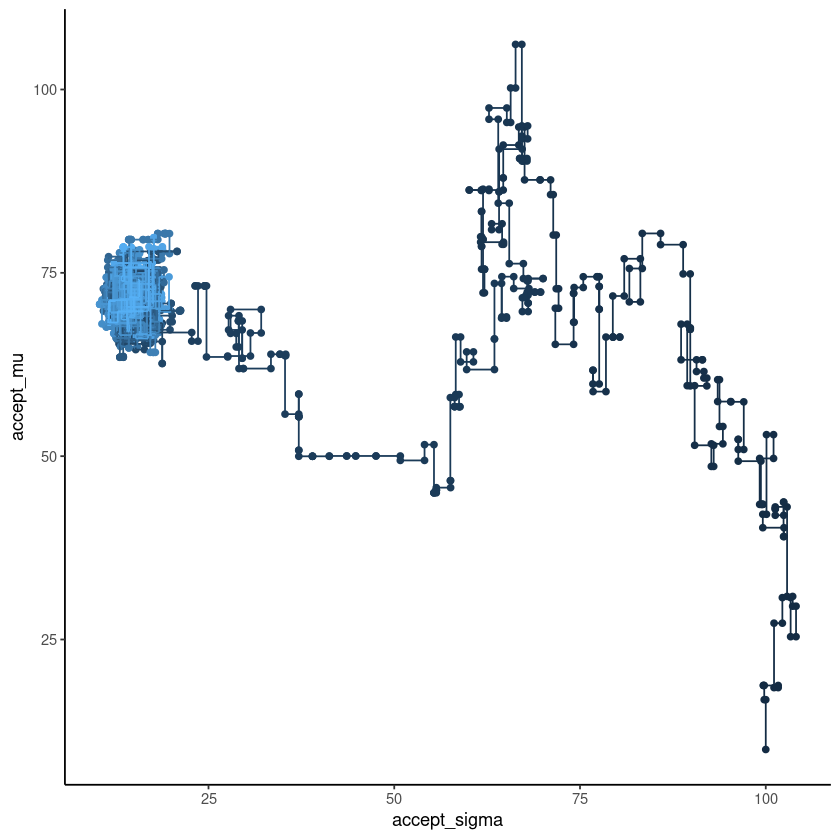

In [3]:
gibbs_sampling(student_results, proposed_mu = 10, proposed_sigma = 100, niter = 1000) %>%
  mutate(series = 1:2001) %>%
  ggplot(aes(x = accept_sigma, y = accept_mu, colour = series)) +
  geom_point() +
  geom_path() +
  theme_classic() +
  theme(legend.position = 'none')

Comparing this to the Metropolis algorithm:

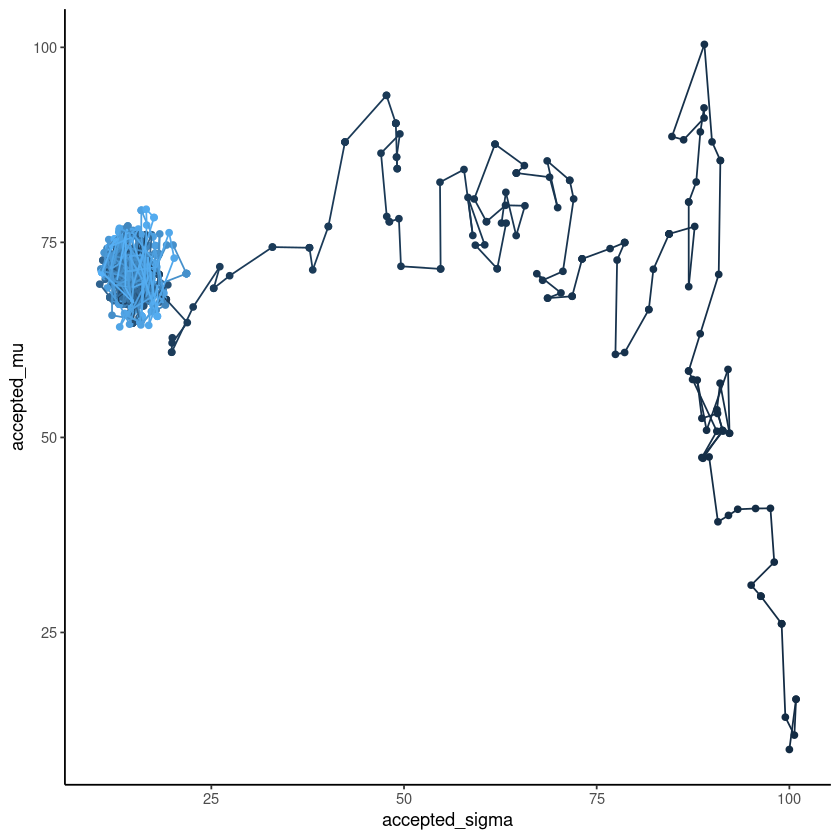

In [4]:
metropolis_algo_multiDim(student_results, proposed_mu = 10, proposed_sigma = 100, niter = 1000) %>%
  mutate(series = 1:1001) %>%
  ggplot(aes(x = accepted_sigma, y = accepted_mu, colour = series)) +
  geom_point() +
  geom_path() +
  theme_classic() +
  theme(legend.position = 'none')

It's clear how the two sampling algorithms differ in their accept-reject procedures.

### Conclusion

In this post, we covered the motivation for more complex sampling methodologies like Gibbs sampling in dealing with cases where the sampled parameters are correlated. In the next post, I will discuss another methodology used in these sampling methods - differential evolution.

<b id="f1">1</b> See this set of [notes](http://www2.stat.duke.edu/~rcs46/modern_bayes17/lecturesModernBayes17/lecture-7/07-gibbs.pdf) on Gibbs sampling for more details [↩](#a1)